In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [96]:
def one_hot_to_label_encoding(data, columns, new_column_name = 'new_col', drop_columns = False):
    data[new_column_name] = sum([(idx + 1) * data[col_name] for idx, col_name in enumerate(columns)])
    if drop_columns:
        data = data.drop(columns, axis=1)
    return data

In [97]:
def filter_by_name_start(data, name_start):
    filtered_columns = data.columns[data.columns.str.startswith(name_start)]
    return filtered_columns

In [98]:
def bar_plot(dataset, feature):
    plt.bar(dataset[feature].value_counts().index, dataset[feature].value_counts())
    plt.xticks(dataset[feature].value_counts().index)
    plt.title(f'Bar plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('counts')
    plt.show()

In [99]:
def plot_hist(dataset, feature):
    plt.hist(dataset[feature], bins = 'fd')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('counts')
    plt.show()

## Data reading and cleaning

### Read data

In [100]:
data = pd.read_csv('data/train.csv')

In [101]:
data.head(1)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.0,0.0,100.0,1849,4


In [102]:
data.shape

(9557, 143)

The data has 143 features with 9557 records.

### Missing data

In [103]:
missing_data = data.isna().sum()

In [104]:
missing_data[missing_data != 0]

v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
dtype: int64

There are missing values for only 5 columns of all 143. The missing data percentag is as follows:
- 71% for montly rent payment `v2a1`
- 76% for the number of tablets household owns `v18q1`
- 82% for years behind in school `rez_esc`
- less than 1% for average years of education for adults (18+) `meaneduc`
- less than 1% for square of the mean years of education of adults (>=18) in the household `SQBmeaned`

The first tree have too much missing data to be imputed good enough, so those will be dropped. `meaneduc` and `SQBmeaned` are realeted and show pretty much same information. With only 5 missing records they can easily be imputed.

In [105]:
data['meaneduc'] = data['meaneduc'].fillna(data['meaneduc'].mean())

In [106]:
assert data['meaneduc'].isna().any() == False

In [107]:
data = data.drop(['v2a1', 'v18q1', 'rez_esc'], axis = 1)

## Feature engineering

In [108]:
data['edjefe'] = data['edjefe'].replace({'no': 0, 'yes': 1}).astype(float)
data['edjefa'] = data['edjefa'].replace({'no': 0, 'yes': 1}).astype(float)
data['dependency'] = data['dependency'].replace({'no': 0, 'yes': 1}).astype(float)

Some of the features will be deleted, because the information provided by them is covered by another feature or are id related (`idhogar`; `ID` is used as index). From other a new feature will be created before deletion.
Such features are:
- `qmobilephone` - a new feature `mobilephone_per_person` is extracted using the number of people of age 12 or older;
- `rooms` and `bedrooms`- a feature `people_per_room` and `people_per_bedroom` is extracted;
- `tipovivi1`, `tipovivi2`, `tipovivi3`, `tipovivi4`, `tipovivi5` - a binary, categorical feature `paying_rent` is extracted

The features below are dropped, because the information provided is mostly covered by another one: 
- `r4h1`, `r4h2`,`r4m1`, `r4m2`, `r4t1`, `r4t2`, `r4t3`, `male`, `female`, `hogar_total`;
- `mobilephone` is binary categorical feature, which shows if household have a mobile phone; that information is also presents in `qmobilephone`, which consists of the total number of phones, with 0 for no phone

In [109]:
data['mobilephone_per_person'] = np.where(data['qmobilephone'] > 0, data['qmobilephone'] / data['r4t2'], 0)
data['people_per_room'] = data['rooms'] / data['tamviv']
data['people_per_bedroom'] = data['bedrooms'] / data['tamviv']
data['paying_rent'] = np.where(
    (data['tipovivi2'] == 1) | (data['tipovivi3'] == 1) | (data['tipovivi4'] == 1),
    1, 0)

In [110]:
data = data.set_index('Id')

In [111]:
data = data.drop(['idhogar', 'rooms', 'bedrooms', 'qmobilephone', 'mobilephone', 'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5',
                 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned',
                 'agesq'], axis = 1)

In [112]:
data.shape

(9557, 124)

### Label encoder

#### Categorical attributes

After the feature engineering there are still 124 columns, most of which categorical. Those are result of one hot encoding. To reduce the dimensions, another encoding strategy is applied - label encoding. 

In [113]:
outside_material_cols = filter_by_name_start(data, 'pared')
floor_material_cols = filter_by_name_start(data, 'piso')
roof_material_cols = filter_by_name_start(data, 'techo')
water_provision_cols = filter_by_name_start(data, 'abastagua')
electricity_cols = data[['public', 'planpri', 'noelec', 'coopele']]
waste_water_connection_cols = filter_by_name_start(data, 'sanitario')
energy_source_for_cooking_cols = filter_by_name_start(data, 'energcocinar')
rubbish_disposal_cols = filter_by_name_start(data, 'elimbasu')
marital_status_cols = filter_by_name_start(data, 'estadocivil')
family_relation_cols = filter_by_name_start(data, 'parentesco')
level_of_education_cols = filter_by_name_start(data, 'instlevel')
region_cols = filter_by_name_start(data, 'lugar')
walls_condition_cols = filter_by_name_start(data, 'epared')
roof_condition_cols = filter_by_name_start(data, 'etecho')
floor_condition_cols = filter_by_name_start(data, 'eviv')

In [114]:
data = one_hot_to_label_encoding(data, outside_material_cols, new_column_name = 'outside_material', drop_columns = True)
data = one_hot_to_label_encoding(data, floor_material_cols, new_column_name = 'floor_material', drop_columns = True)
data = one_hot_to_label_encoding(data, roof_material_cols, new_column_name = 'roof_material', drop_columns = True)
data = one_hot_to_label_encoding(data, water_provision_cols, new_column_name = 'water_provisio', drop_columns = True)
data = one_hot_to_label_encoding(data, electricity_cols, new_column_name = 'electricity', drop_columns = True)
data = one_hot_to_label_encoding(data, waste_water_connection_cols, new_column_name = 'waste_water_connection', drop_columns = True)
data = one_hot_to_label_encoding(data, energy_source_for_cooking_cols, new_column_name = 'energy_for_cooking', drop_columns = True)
data = one_hot_to_label_encoding(data, rubbish_disposal_cols, new_column_name = 'rubbish_disposal', drop_columns = True)
data = one_hot_to_label_encoding(data, marital_status_cols, new_column_name = 'marital_status', drop_columns = True)
data = one_hot_to_label_encoding(data, family_relation_cols, new_column_name = 'family_relation', drop_columns = True)
data = one_hot_to_label_encoding(data, level_of_education_cols, new_column_name = 'level_of_education', drop_columns = True)
data = one_hot_to_label_encoding(data, region_cols, new_column_name = 'region', drop_columns = True)
data = one_hot_to_label_encoding(data, walls_condition_cols, new_column_name = 'walls_condition', drop_columns = True)
data = one_hot_to_label_encoding(data, roof_condition_cols, new_column_name = 'roof_condition', drop_columns = True)
data = one_hot_to_label_encoding(data, floor_condition_cols, new_column_name = 'floor_condition', drop_columns = True)

In [115]:
data = data.drop(['r4h1', 'r4h2', 'r4m1', 'r4m2', 'r4t1', 'r4t2', 'r4t3',
                  'male', 'female', 'hogar_total'], axis = 1)

In [116]:
numerical_columns = ['r4h3', 'r4m3', 'tamhog', 'tamhog', 'escolari', 'hhsize', 'hogar_nin', 'hogar_adul', 'hogar_mayor', 'dependency', 
                    'edjefe', 'edjefa', 'meaneduc', 'overcrowding', 'age', 'mobilephone_per_person', 'people_per_room', 'people_per_bedroom']
categorical_columns = data.columns[~data.columns.isin(numerical_columns)]

In [117]:
numerical_columns = ['r4h3', 'r4m3', 'tamhog', 'tamhog', 'escolari', 'hhsize', 'hogar_nin', 'hogar_adul', 'hogar_mayor', 'dependency', 
                    'edjefe', 'edjefa', 'meaneduc', 'overcrowding', 'age', 'mobilephone_per_person', 'people_per_room', 'people_per_bedroom']
categorical_columns = data.columns[~data.columns.isin(numerical_columns)]

In [118]:
data.shape

(9557, 46)

#### Target

In [119]:
labels_original = ['extreme poverty', 'moderate poverty', 'vulnerable households', 'non vulnerable households']

In [120]:
target = data['Target']
attributes = data.drop(['Target'], axis = 1)

In [121]:
label_encoder = LabelEncoder().fit(target.unique())
target_encoded = label_encoder.transform(target)

## Exploratory data analysis

### Correlations

After the preprocessing data has 46 features. From those only 14 features have weak correlation (between 0.2 and 0.35). 
Positive correlation is present with 10 features:
- `meaneduc` - average years of education for adults (18+)
- `walls_condition`
- `cielorazo` - if the house has ceiling
- `floor_condition`
- `escolari` - years of schooling
- `level_of_education`
- `roof_condition`
- `edjefe` -  years of education of male head of household, based on the interaction of `escolari`(years of education), head of household and gender
- `v18q` - owns a tablet 
- `people_per_room`

Negative correlation is present in 4 features:
- `hogar_nin` - Number of children 0 to 19 in household
- `overcrowding` - # people per room
- `outside_material`
- `floor_material`

In [122]:
corrs = data.corr()

In [123]:
(corrs['Target'][corrs['Target'] > 0.2]).sort_values(ascending = False)

Target                1.000000
meaneduc              0.335161
walls_condition       0.306293
cielorazo             0.304421
floor_condition       0.303165
escolari              0.302305
level_of_education    0.296871
roof_condition        0.268440
edjefe                0.243215
v18q                  0.238864
people_per_room       0.203374
Name: Target, dtype: float64

In [124]:
(corrs['Target'][corrs['Target'] < -0.2]).sort_values()

hogar_nin          -0.328199
overcrowding       -0.289110
outside_material   -0.253870
floor_material     -0.218262
Name: Target, dtype: float64

### Sample group properties

The data consists of 9557 recors of which 2973 are heads of a household. The mean age is 34 years old and the maximum age is 97.

In [125]:
data.shape[0]

9557

In [126]:
data['family_relation'][data['family_relation'] == 1].value_counts()

1    2973
Name: family_relation, dtype: int64

In [127]:
data['age'].describe()

count    9557.000000
mean       34.303547
std        21.612261
min         0.000000
25%        17.000000
50%        31.000000
75%        51.000000
max        97.000000
Name: age, dtype: float64


From those 6829 or around 72% are living in urban area and the other 2728 - in rural.

In [128]:
data['area1'].value_counts()

1    6829
0    2728
Name: area1, dtype: int64

There are almost 2 times more male heads of household than female.

In [129]:
data['edjefe'][data['edjefe'] == 0].value_counts()

0.0    3762
Name: edjefe, dtype: int64

In [130]:
data['edjefa'][data['edjefa'] == 0].value_counts()

0.0    6230
Name: edjefa, dtype: int64

The target classes are 4 and they are imbalanced. 62.7% of all records are classified as non vulnerable households (class 4), 16,7% are classified as moderate poverty (class 2), 12.6% - vulnerable households (class 3) and 8% - extreme poverty (class 1).

In [131]:
data['Target'].value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

### Rooms and overcrowding

The plot below show that households where more that 7 or only 1 person is living are not common. Most households have 3, 4 or 5 people living.

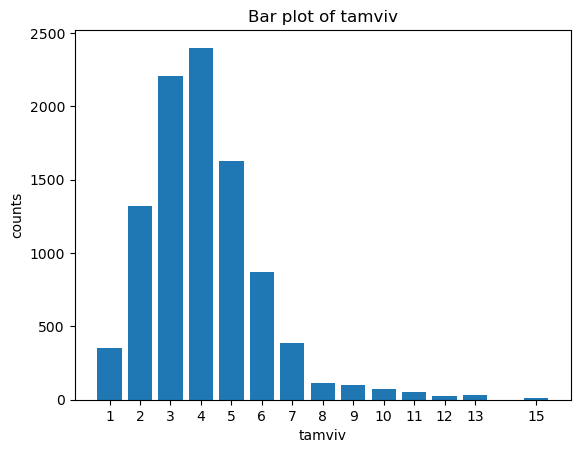

In [132]:
bar_plot(data, 'tamviv')

### Education

Most common years spend at school are 0, 6 or 11. More that 17 years are very rare. Comparing the male and female head of household's year of education, it can be seen that females have mostly spend 0 years of education. Of course this might be a result of initial missing data imputation.

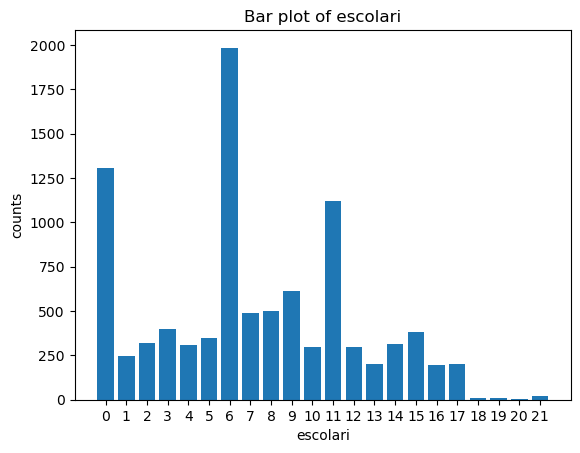

In [133]:
bar_plot(data, 'escolari')

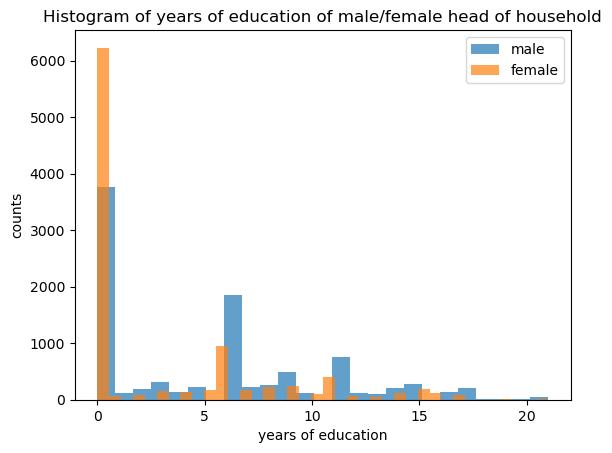

In [134]:
plt.hist(data['edjefe'], bins = 'fd', alpha = 0.7, label = 'male')
plt.hist(data['edjefa'], bins = 'fd', alpha = 0.7, label = 'female')
plt.title('Histogram of years of education of male/female head of household')
plt.xlabel('years of education')
plt.ylabel('counts')
plt.legend()
plt.show()